## Analysis notebook

In this notebook I'll be running the pymc3 model code and trying to interpret results from the posterior. 

Of particular interest is the way $\theta_{4}$ and $\theta_{5}$ behave in the hierarchical context, as the MLE of fully pooled data shows the behaviour you would expect (i.e. increasing probability of long pause with fullness) but preliminary runs of the inference disagree!

First, load the data:

In [1]:
%pwd

u'/home/tmcgrath/Dropbox/Tom/PhD/projects/PDMP_modelling'

In [2]:
import sys
import os
import theano
import theano.tensor as tt
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import PDMP_ll as ll
import cPickle as pickle

#theano.config.mode = 'FAST_COMPILE'
theano.config.mode = 'FAST_RUN'

run_name = 'all_data'

"""
Data import
"""
min_num_animals = 5

root_data_dir = 'all_data/'
group_paths = os.listdir(root_data_dir)
print group_paths

def data_from_file(filename):
    data = np.loadtxt(filename,delimiter='\t',usecols=(0,1,2,3,4))

    f_lengths = data[:,0]
    g_starts = data[:,1]
    rates = data[:,2]
    p_lengths = data[:,3]
    g_ends = data[:,4]

    obs = [f_lengths, g_starts, rates, p_lengths, g_ends]

    return obs

## Iterate over groups
data_holder = []
idx_holder = []
group_idx_holder = []
group_sizes = []
count = 0

subj_data = []

for group_num, path in enumerate(group_paths):
    group_path = root_data_dir+path
    
    if len(os.listdir(group_path)) >= min_num_animals:
        group_sizes.append(len(os.listdir(group_path)))
        print "Using ", group_path
        ## Iterate over members of group
        for filename in os.listdir(group_path):
            if filename [-3:] != 'CSV':
                continue
                
            print filename

            new_data = data_from_file(group_path+'/'+filename)
            data_holder.append(new_data)

            ## Create index holders
            idx_holder.append(count*np.ones(len(new_data[0])))
            group_idx_holder.append(group_num*np.ones(len(new_data[0])))
            
            ## Store subject data
            subj_data.append([group_path, filename])

            count += 1
        
    else:
        print "Skipping ", group_path

data = np.hstack(data_holder)
idx = np.hstack(idx_holder)
group_idx = np.hstack(group_idx_holder)
idx = idx.astype(int)
group_idx = group_idx.astype(int)

num_animals = len(data_holder)
num_groups = np.max(group_idx) + 1

print "Number of data points: ", len(group_idx)
print "Number of animals: ", num_animals
print "Number of groups: ", num_groups

print group_paths

['PYY_300.0_R_L', 'PYY_1.5_R_D', 'PYY_7.5_R_D', 'PYY_7.5_R_L', 'saline_0.0_N_D', 'LiCL_32.0_R_L', 'Lep_2.0_R_D', 'PYY_1.5_R_L', 'LiCL_32.0_R_D', 'saline_0.0_R_D', 'PYY_300.0_R_D', 'saline_0.0_R_L', 'saline_0.0_N_L']
Using  all_data/PYY_300.0_R_L
PYY_300.0_R_L_6_2014-10-27.B0106.CSV
PYY_300.0_R_L_5_2014-10-27.B0105.CSV
PYY_300.0_R_L_11_2014-11-03.B0111.CSV
PYY_300.0_R_L_3_2014-10-27.B0103.CSV
PYY_300.0_R_L_7_2014-10-17.B0107.CSV
PYY_300.0_R_L_13_2014-11-03.B0113.CSV
PYY_300.0_R_L_1_2014-10-17.B0101.CSV
PYY_300.0_R_L_4_2014-10-27.B0104.CSV
PYY_300.0_R_L_12_2014-11-03.B0112.CSV
PYY_300.0_R_L_8_2014-10-17.B0108.CSV
Using  all_data/PYY_1.5_R_D
PYY_1.5_R_D_1_2015-02-17.B0101.CSV
PYY_1.5_R_D_11_2015-02-09.B0111.CSV
PYY_1.5_R_D_5_2015-02-09.B0105.CSV
PYY_1.5_R_D_5_2015-02-17.B0105.CSV
PYY_1.5_R_D_13_2015-02-09.B0113.CSV
PYY_1.5_R_D_9_2015-02-17.B0109.CSV
PYY_1.5_R_D_7_2015-02-17.B0107.CSV
PYY_1.5_R_D_7_2015-02-09.B0107.CSV
PYY_1.5_R_D_5_2015-02-23.B0105.CSV
PYY_1.5_R_D_14_2015-02-23.B0114.CSV


In [3]:
print data.shape
print group_sizes

for i in subj_data:
    print i[1].split('_')

(5, 4966)
[10, 12, 11, 10, 9, 10, 6, 9, 10, 28, 12, 25, 9]
['PYY', '300.0', 'R', 'L', '6', '2014-10-27.B0106.CSV']
['PYY', '300.0', 'R', 'L', '5', '2014-10-27.B0105.CSV']
['PYY', '300.0', 'R', 'L', '11', '2014-11-03.B0111.CSV']
['PYY', '300.0', 'R', 'L', '3', '2014-10-27.B0103.CSV']
['PYY', '300.0', 'R', 'L', '7', '2014-10-17.B0107.CSV']
['PYY', '300.0', 'R', 'L', '13', '2014-11-03.B0113.CSV']
['PYY', '300.0', 'R', 'L', '1', '2014-10-17.B0101.CSV']
['PYY', '300.0', 'R', 'L', '4', '2014-10-27.B0104.CSV']
['PYY', '300.0', 'R', 'L', '12', '2014-11-03.B0112.CSV']
['PYY', '300.0', 'R', 'L', '8', '2014-10-17.B0108.CSV']
['PYY', '1.5', 'R', 'D', '1', '2015-02-17.B0101.CSV']
['PYY', '1.5', 'R', 'D', '11', '2015-02-09.B0111.CSV']
['PYY', '1.5', 'R', 'D', '5', '2015-02-09.B0105.CSV']
['PYY', '1.5', 'R', 'D', '5', '2015-02-17.B0105.CSV']
['PYY', '1.5', 'R', 'D', '13', '2015-02-09.B0113.CSV']
['PYY', '1.5', 'R', 'D', '9', '2015-02-17.B0109.CSV']
['PYY', '1.5', 'R', 'D', '7', '2015-02-17.B0107.CSV'

## Running the pymc3 model

This code just runs the pymc3 inference as we've done before.

In [4]:
## Set constants
k1 = 0.00055
num_samples = 3000
nchains = 1
ntune = 1000

## Model setup
with pm.Model() as model:
    ## Group mean
    #means = [-2, -2.35, -2.8, 1, 1, -2, 3.5, 2] # from unpooled data, all vars
    means = [-2, -2, -3, 1, 1, -2, 3, 2] # from unpooled data, all vars
    #means = [-2, -2.35, -2.8] # from unpooled data, theta1 to theta4
    #means = [-1, -2, -2, 3.5, 2] # from unpooled data, theta5 to theta9
    #means = [-1, -1, -1] # test how strongly priors affect posterior
    num_vars = len(means)
    cov = np.eye(num_vars)

    mu = pm.Normal('mu', mu=means, sd=2, shape=(num_groups,num_vars))

    #mu_print = theano.printing.Print('mu')(mu)

    theta_holder = []
    for i in range(0, num_groups):
        ## Create covariance matrix from LKJ
        sd_dist = pm.HalfCauchy.dist(beta=2.5, shape=num_vars)
        packed_chol = pm.LKJCholeskyCov('chol_cov'+str(i), eta=1, n=num_vars, sd_dist=sd_dist)
        chol = pm.expand_packed_triangular(num_vars, packed_chol, lower=True)

        theta_tilde = pm.Normal('theta_tilde'+str(i), mu=0, sd=1, shape=(group_sizes[i], num_vars))
        theta_gp = tt.dot(chol, theta_tilde.T).T # have to take transpose to fit with distribution shape
        theta_holder.append(theta_gp)

    thetas = tt.concatenate(theta_holder)

    theta1 = pm.Deterministic('theta1', mu[group_idx,0] + thetas[idx,0]) 
    theta2 = pm.Deterministic('theta2', mu[group_idx,1] + thetas[idx,1]) 
    theta3 = pm.Deterministic('theta3', mu[group_idx,2] + thetas[idx,2]) 
    theta4 = pm.Deterministic('theta4', mu[group_idx,3] + thetas[idx,3]) 
    theta5 = pm.Deterministic('theta5', mu[group_idx,4] + thetas[idx,4]) 
    theta6 = pm.Deterministic('theta6', mu[group_idx,5] + thetas[idx,5]) 
    theta7 = pm.Deterministic('theta7', mu[group_idx,6] + thetas[idx,6]) 
    theta8 = pm.Deterministic('theta8', mu[group_idx,7] + thetas[idx,7])
    
    """
    Power-transform
    """
    p10_theta1 = tt.pow(10., theta1)
    p10_theta2 = tt.pow(10., theta2)
    p10_theta3 = tt.pow(10., theta3)
    p10_theta6 = tt.pow(10., theta6)
    p10_theta7 = tt.pow(10., theta7)
    p10_theta8 = tt.pow(10., theta8)

    ## Likelihood of observations

    ## Exponential feeding bout length
    feeding_lengths = pm.Exponential('f_len', p10_theta1, observed=data[0,:])

    ## Normal feeding bout rate
    rates = pm.Normal('rate', p10_theta2, sd=p10_theta3, observed=data[2,:])

    ## Pause likelihood
    pauses = ll.pause_ll('pause', theta4, theta5, p10_theta6, p10_theta7, p10_theta8, k1, observed=data)

    ## Checking out different step methods to see which works
    # NUTS w/o ADVI - currently fails on LKJCholeskyCov
    trace = pm.sample(num_samples, tune=ntune, njobs=nchains,
                      step=pm.NUTS())

    pm.traceplot(trace)
    plt.savefig('all_data_cov_diag_new.png')
    plt.show()
    
pickle.dump(trace, open(run_name+"_trace.p", "wb"))
pickle.dump(subj_data, open(run_name+"_subj.p", "wb"))
pickle.dump(group_paths, open(run_name+"_paths.p", "wb"))

100%|██████████| 4000/4000 [4:50:34<00:00,  4.38s/it]  /home/tmcgrath/anaconda2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.667140656354, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [5]:
print trace['mu'].shape

(3000, 13, 8)


In [6]:
print trace['mu'][::10,0,0].shape

(300,)


0
1
2
3
4
5
6
7
['PYY_300.0_R_L', 'PYY_1.5_R_D', 'PYY_7.5_R_D', 'PYY_7.5_R_L', 'saline_0.0_N_D', 'LiCL_32.0_R_L', 'Lep_2.0_R_D', 'PYY_1.5_R_L', 'LiCL_32.0_R_D', 'saline_0.0_R_D', 'PYY_300.0_R_D', 'saline_0.0_R_L', 'saline_0.0_N_L']


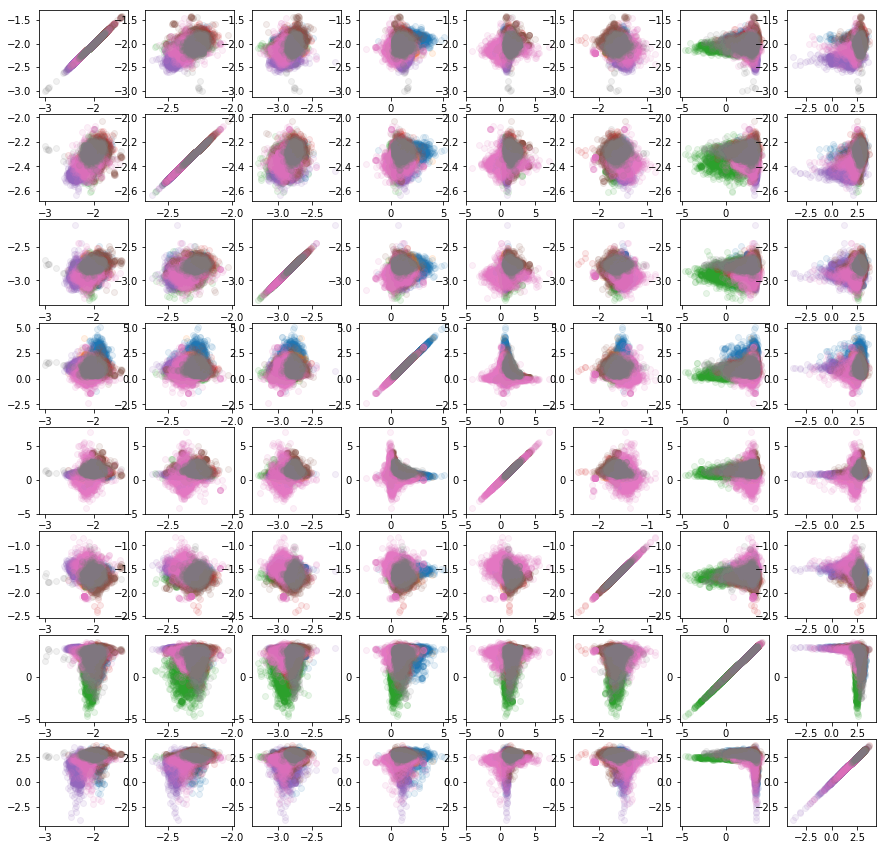

In [7]:
#trace = pickle.load(open("all_groups_trace.p", "rb"))
num_vars = 8

fig, axes = plt.subplots(num_vars,num_vars,figsize=(15,15))

thin_param = 1
tune_param = 0
alpha = 0.1

#group_list = [7, 13, 15, 3]
group_list = [0,1,2,3,4,5,6,7]
#group_list = np.arange(len(group_paths))

for first_theta in range(0,num_vars):
    print first_theta
    for second_theta in range(0,num_vars):
        #for i in range(0,num_groups):
        for i in group_list:
            #axes[second_theta, first_theta].scatter(np.mean(trace['mu'][tune_param::thin_param,i,first_theta]), np.mean(trace['mu'][tune_param::thin_param,i,second_theta]), alpha=alpha)
            axes[second_theta, first_theta].scatter(trace['mu'][tune_param::thin_param,i,first_theta], trace['mu'][tune_param::thin_param,i,second_theta], alpha=alpha, label=group_paths[i])            

print group_paths

plt.savefig(run_name+'_cov.png')            
plt.show()